# Decision Tree

In this notebook, we will introduce one of the most popular supervised machine learning algorithms called decision tree. It can be used for both regression and classification algorithm. Here we mainly discuss decision tree from classification perspective.

In [1]:
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import uuid
import copy

from abc import ABCMeta, abstractmethod

%matplotlib inline

## Introduction 

<p><center>![Basic Tree Terminology](../../images/png/basic_tree.png)</center></p>
<p><center><b>Figure 1</b>: Basic Tree Terminology</center></p>


## Building Tree Model

<p><center>![Basic Tree Terminology](../../images/png/tree_building.png)</center></p>
<p><center><b>Figure 2</b>: Basic Tree Terminology</center></p>


## Splitting Data into Different Regions

<p><center>![Basic Tree Terminology](../../images/png/tree_partition.png)</center></p>
<p><center><b>Figure 2</b>: Basic Tree Terminology</center></p>

## How to Choose Best Split?

## Decision Tree Algorithm

$$H(S)=-\sum_{c \in C}p(c)log_2\big(p(c)\big)$$

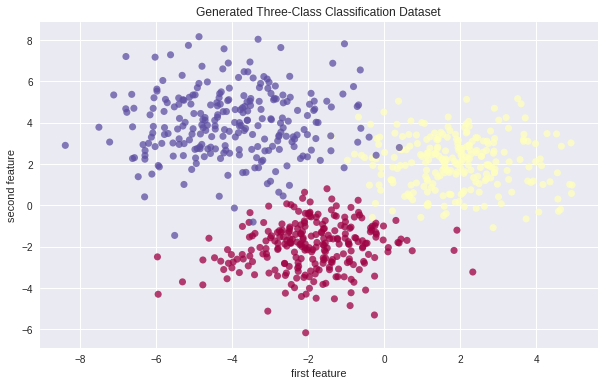

In [2]:
N = 250
np.random.seed(1024)

mean_cls_0 = np.array([-2, -2])
cov_cls_0 = np.array([[1.5, 0], [0, 1.5]])
x0 = np.random.multivariate_normal(mean=mean_cls_0, cov=cov_cls_0, size=N)
y0 = np.zeros(N)

mean_cls_1 = np.array([2, 2])
cov_cls_1 = np.array([[1.5, 0], [0, 1.5]])
x1 = np.random.multivariate_normal(mean=mean_cls_1, cov=cov_cls_1, size=N)
y1 = np.ones(N)

mean_cls_2 = np.array([-4, 4])
cov_cls_2 = np.array([[2.5, 0], [0, 2.5]])
x2 = np.random.multivariate_normal(mean=mean_cls_2, cov=cov_cls_2, size=N)
y2 = np.full(N, 2)

X_train = np.row_stack((x0, x1, x2))
y_train = np.concatenate((y0, y1, y2)).astype(np.int16)

fig = plt.figure(figsize=(10, 6))
axes = plt.axes()
axes.scatter(
    X_train[:, 0],
    X_train[:, 1],
    c=y_train,
    s=50,
    cmap=plt.cm.Spectral,
    alpha=0.75,
    edgecolors='none')
axes.set_xlabel('first feature')
axes.set_ylabel('second feature')
axes.set_title('Generated Three-Class Classification Dataset')
plt.show()

In [3]:
def entropy(x):
    # remove all zero and negative values
    x = x[x > 0]
    return -np.sum(x * np.log2(x))

$$I = H(S) - \sum_{i \in (1, 2)}\frac{S^{i}}{S}H(S^{i})$$

In [4]:
def entropy(x):
    x = x[x > 0]
    return -np.sum(x * np.log(x))


def information_gain(y, y_left, y_right):
    n = y.shape[0]
    n_l = y_left.shape[0]
    if n_l == 0:
        H_l = 0.0
    else:
        H_l = entropy(y_left.mean(axis=0))

    n_r = y_right.shape[0]
    if n_r == 0:
        H_r = 0
    else:
        H_r = entropy(y_right.mean(axis=0))

    H = entropy(y.mean(axis=0))
    return H - n_l / n * H_l - n_r / n * H_r


def predict_node_label(values, num_distinct_classes):
    probabilities = predict_node_probability(values, num_distinct_classes)
    return np.argmax(probabilities)


def predict_node_probability(values, num_distinct_classes):
    return np.bincount(values, minlength=num_distinct_classes) / values.shape[0]

class HyperParameterException(Exception):
    pass

In [5]:
class Node(object):
    def __init__(self, node_id=None, description=None):
        self.id = node_id
        self.description = description

    def set_id(self, id):
        self.id = id

    def get_id(self):
        return str(self.id)

    def set_description(self, description):
        self.description = description

    def get_description(self):
        return self.description


class Leaf(Node):
    def __init__(self, values, n_classes=None, node_id=None, description=None):
        Node.__init__(self, node_id, description)
        self.values = values

    def get_values(self):
        return self.values


class Internal(Node):
    def __init__(self, dim, threshold, left_child, right_child, node_id=None, description=None):
        Node.__init__(self, node_id, description)
        self.dim = dim
        self.threshold = threshold
        self.left_child = left_child
        self.right_child = right_child

In [6]:
class BaseTree(metaclass=ABCMeta):
    def __init__(self, max_depth=None, n_min_leaf=2, n_trials=None):
        self.max_depth = max_depth
        self.n_min_leaf = n_min_leaf
        self.n_trials = n_trials
        self.root_node = None
        self.num_classes = None

    def fit(self, X, y):
        self.num_classes = np.unique(y).shape[0]
        self._fit_training_data(X, y,
                                max_depth=self.max_depth,
                                n_min_leaf=self.n_min_leaf,
                                n_trials=self.n_trials)

    def predict(self, X):
        y_predict = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            pointer = copy.copy(self.root_node);
            y_predict[i] = self._predict_single_data_point(X[i, :], pointer)
        return y_predict

    def visualize(self, file_name, file_format='png'):
        queue = [self.root_node]
        children = {}
        graph = gv.Digraph(format=file_format)

        while queue:
            vertex = queue.pop(0)
            graph.node(name=vertex.get_id(), label=vertex.get_description())
            if type(vertex) is Internal:
                queue.append(vertex.right_child)
                queue.append(vertex.left_child)
                children[vertex.get_id()] = (vertex.right_child.get_id(),
                                             vertex.left_child.get_id())

        for key, val in children.items():
            true_flag = True
            for child in val:
                if true_flag:
                    graph.edge(key, child, 'True')
                    true_flag = False
                else:
                    graph.edge(key, child, 'False')
        graph.render(file_name)

    # private methods
    def _build_node_description(self, values):
        probabilities = predict_node_probability(values, self.num_classes)
        desc = ''
        for i in range(probabilities.shape[0]):
            desc += 'class: {}  prob: {} \n'.format(i, probabilities[i])
        desc += 'samples: {}\n'.format(values.shape[0])
        return desc

    def _fit_training_data(self, X, y, max_depth=None, n_min_leaf=None, n_trials=None):
        if np.all(y == y[0]):
            return Leaf(y, self.num_classes, node_id=uuid.uuid4(),
                        description=self._build_node_description(y))

        if max_depth is not None and max_depth <= 0:
            return Leaf(y, self.num_classes, node_id=uuid.uuid4(),
                        description=self._build_node_description(y))

        split_parameters = self._split_parameters(X,
                                                  y,
                                                  n_min_leaf=n_min_leaf,
                                                  n_trials=n_trials)
        if split_parameters is None:
            return Leaf(y, self.num_classes, node_id=uuid.uuid4(),
                        description=self._build_node_description(y))

        split_dim, split_threshold = split_parameters
        mask_left = X[:, split_dim] <= split_threshold
        mask_right = np.logical_not(mask_left)

        left_child = self._fit_training_data(
            X[mask_left],
            y[mask_left],
            max_depth=max_depth - 1 if max_depth is not None else None)

        right_child = self._fit_training_data(
            X[mask_right],
            y[mask_right],
            max_depth=max_depth - 1 if max_depth is not None else None)

        description = 'feature:[{}] <= {}'.format(split_dim, split_threshold)
        self.root_node = Internal(
            dim=split_dim,
            threshold=split_threshold,
            left_child=left_child,
            right_child=right_child,
            node_id=uuid.uuid4(),
            description=description)
        return self.root_node

    def _split_parameters(self, X, Y, n_min_leaf=None, n_trials=None):

        if n_min_leaf is not None and n_min_leaf >= Y.shape[0]:
            return None

        candidate_indices = None
        if n_trials is not None:
            if n_trials > X.shape[1]:
                raise HyperParameterException('n_trials should be less than number of features')
            else:
                candidate_indices = np.random.choice(X.shape[1], size=n_trials, replace=False)

        best_gain = float('-inf')
        best_dimension = None
        best_threshold = None
        if candidate_indices is None:
            candidate_indices = range(X.shape[1])

        for dim in candidate_indices:
            feature = X[:, dim]
            threshold, info_grain = self._find_best_split_threshold(feature, Y)
            if info_grain >= best_gain:
                best_dimension = dim
                best_gain = info_grain
                best_threshold = threshold

        if best_threshold is None:
            return None
        else:
            return best_dimension, best_threshold

    @abstractmethod
    def _find_best_split_threshold(self, feature_vector, response):
        pass

    @abstractmethod
    def _predict_single_data_point(self, X, node, emit_probability=False):
        pass


class ClassificationTree(BaseTree):
    def __init__(self, max_depth=None, n_min_leaf=2, n_trials=None):
        super().__init__(max_depth, n_min_leaf, n_trials)

    def predict_probability(self, X):
        y_predict = np.zeros((X.shape[0], self.num_classes))
        for i in range(X.shape[0]):
            pointer = copy.copy(self.root_node);
            y_predict[i,] = self._predict_single_data_point(X[i, :], pointer, emit_probability=True)
        return y_predict

    def _find_best_split_threshold(self, feature_vector, response):
        unique_features = np.unique(feature_vector)
        best_info_gain = float('-inf')
        best_category = None
        for feature in range(unique_features.shape[0]):
            less_than_or_eq_indices = np.where(feature_vector <= unique_features[feature])[0]
            greater_than_indices = np.where(feature_vector > unique_features[feature])[0]
            info_gain = information_gain(response,
                                         response[less_than_or_eq_indices],
                                         response[greater_than_indices])
            if info_gain > best_info_gain:
                best_info_gain = info_gain
                best_category = unique_features[feature]
        return best_category, best_info_gain

    def _predict_single_data_point(self, X, node, emit_probability=False):
        if type(node) is Leaf:
            if emit_probability:
                return predict_node_probability(node.get_values(), self.num_classes)
            else:
                return predict_node_label(node.get_values(), self.num_classes)
        else:
            dim = node.dim
            feature = X[dim]
            if feature <= node.threshold:
                return self._predict_single_data_point(X, node.left_child, emit_probability)
            else:
                return self._predict_single_data_point(X, node.right_child, emit_probability)


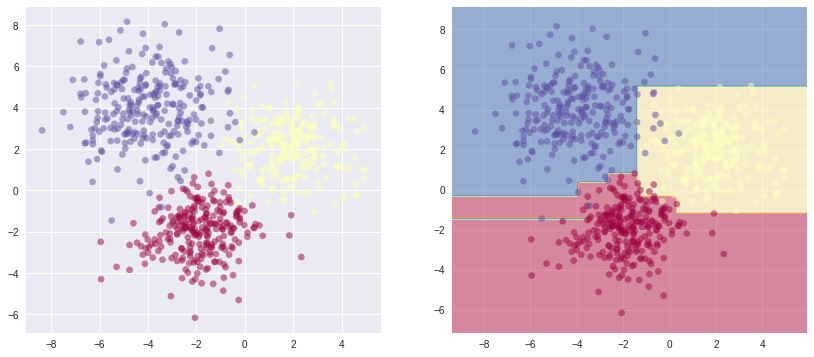

In [7]:
model = ClassificationTree(max_depth=5, n_min_leaf=15)
model.fit(X_train, y_train)

x0_features = np.arange(X_train[:, 0].min() - 1, X_train[:, 0].max() + 1, 0.05)
x1_features = np.arange(X_train[:, 1].min() - 1, X_train[:, 1].max() + 1, 0.05)

x0_features, x1_features = np.meshgrid(x0_features, x1_features)

y_pred = model.predict(
    np.column_stack((x0_features.flatten(), x1_features.flatten())))
y_pred = y_pred.reshape(x0_features.shape)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.scatter(
    X_train[:, 0],
    X_train[:, 1],
    c=y_train,
    s=45,
    cmap=plt.cm.Spectral,
    alpha=0.5,
    edgecolors='none')

ax2.contourf(x0_features, x1_features, y_pred, alpha=0.5, cmap=plt.cm.Spectral)
ax2.scatter(
    X_train[:, 0],
    X_train[:, 1],
    c=y_train,
    s=45,
    cmap=plt.cm.Spectral,
    alpha=0.5,
    edgecolors='none')

plt.show()

## References and Further Reading

1. https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/decisionForests_MSR_TR_2011_114.pdf [Decision Forests for Classification, Regression, Density Estimation, Manifold Learning and Semi-Supervised Learning]

2. 